# Estimate the Gas Mass

Here, we obtain an estimate for the mas of the cold molcular gas traced by the CO(3-2) line. We ectract S/N > 3 emission from each aperture and fit the spectra by hand. The result is used to estimate the $H_2$ gas mass. 

In `Part 1`, we fit the spectrum using `multiple gaussians`

In `Part 2`, we estimate the distribution of the gas mass

In `Part 3`, we check to see how different weighting schemes and velocity widths impact the total gas mass estimated

In [1]:
#path to beads
my_path = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
from __future__ import division
import sys
import importlib

#numpy
import numpy as np

#astropy
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from regions import Regions

#matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#pv stuff

from spectral_cube import SpectralCube

#seaborn
import seaborn as sns

from matplotlib.gridspec import GridSpec
from astropy.wcs import WCS

#warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import my own functions: you can see them in full in the utils folder
util_path = my_path + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as af

In [40]:
importlib.reload(af)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

In [5]:
#About
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s')

In [6]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

In [7]:

file_path = 'Analysis/almaBeads/cannon/'
co32_file = my_path + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'

m0_file = my_path + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M0.fits'

fig_path = my_path + 'Figures/paper/'

In [9]:
#list of cubes
velocity_resolutions = [10, 20, 40, 80]

vcube_files = [''.join((my_path, 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_{}kms_natural_notaper'
                        '.image.pbcor.fits'.format(vel))) for vel in velocity_resolutions]


In [10]:
#moment files for each cube
m0_files = [vfile[:-5]+ '_M0.fits' for vfile in vcube_files]
m1_files = [vfile[:-5]+ '_M1.fits' for vfile in vcube_files]
m2_files = [vfile[:-5]+ '_M2.fits' for vfile in vcube_files]

## 1. Estimate gas mass for 20 km/s cube

#### 1. Estimate gas mass for 20 km/s cube
We used the ALMA data reduction pipeline to bin the ALMA cubes to different velocity resolutions of 10, 20, 40 and 80 km/s. We will obtain a gas mass estimate for each of these bins, to check if binning impacts our estimates by a significant amount


In [8]:
vcube_file = my_path + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'
m0_file = vcube_file[:-5]+ '_M0.fits'
m1_file = vcube_file[:-5]+ '_M1.fits'
m2_file = vcube_file[:-5]+ '_M2.fits'

### Extract Spectra using Spectral-Cube and DS9

First, we draw apertures around the areas we would like to fit using the mom0 map in DS9. I create one region encompassing all emission (total). We can't resolve the individual beads, but `alma_moment_maps.ipynb` showed us there are 3 coherent structures in velocity space present. We'll refer to these regions as `north, center and south`.


In [22]:
region_string=""""
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
ellipse(232.7936870,34.2403425,0.912",1.387",340.36443) #north
ellipse(232.7938088,34.2397973,0.959",0.870",327.30702) #center
ellipse(232.7940860,34.2397661,0.834",1.250",22.661828) #south
ellipse(232.7938130,34.2400682,1.400",2.363",335.34583) #total
"""

In [10]:
m0cmap, m1cmap, m2cmap =sns.light_palette("seagreen", as_cmap=True), cm.Blues,  sns.color_palette("mako_r", as_cmap=True)

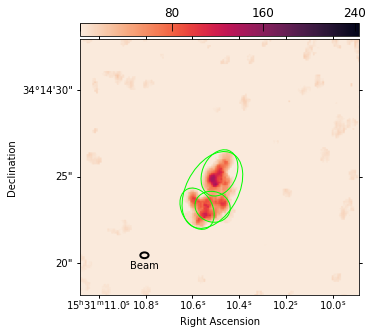

In [14]:
hdu, header, wcs = pf.open_fits(m0_file, naxis=2)
fig = pf.plot_all_moments([m0_file], header, region_string=region_string, ncols=1)

In [23]:
lines = region_string.splitlines(keepends=False)[4:]

regions = [Regions.parse('fk5; {}'.format(line), format='ds9') for line in lines]


extract emission from each region using `SpectralCube`

In [26]:
region_names = ['North', 'Center', 'South', 'Total']
velocity_ranges = [[20, 220], [230, 440], [450, 660], [-680, 900]] #north, center, south, total

region_cubes = []

for idr, region_type in enumerate(regions):


    cube = SpectralCube.read(vcube_file)
    ap_cube = cube.subcube_from_regions(region_type) 

    region_cubes.append(ap_cube)
    print(f'region: {region_names[idr]}')

region: North
region: Center
region: South
region: Total


In [27]:
north_region_cube = region_cubes[0]
center_region_cube = region_cubes[1]
south_region_cube = region_cubes[2]
total_region_cube = region_cubes[3]

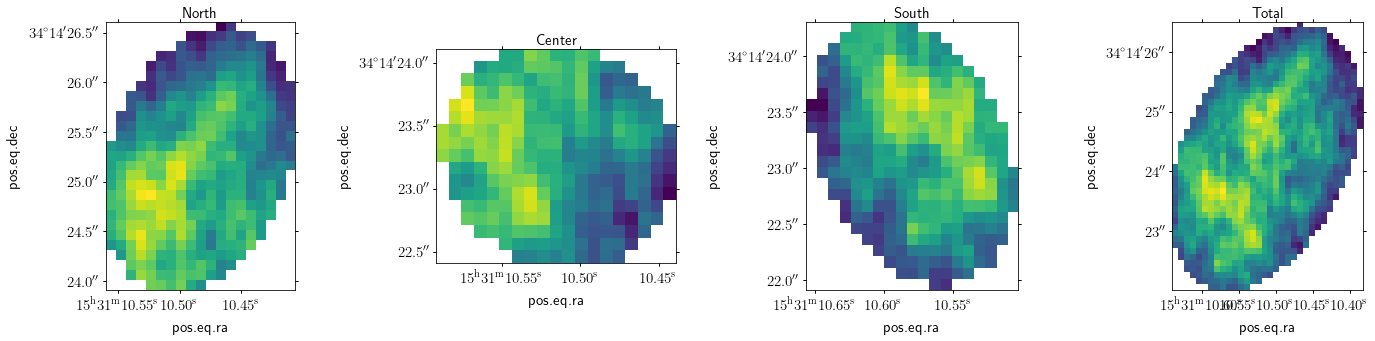

In [28]:
#check that the areas selected are correct
pf.styleplots()

fig = plt.figure(figsize=(20, 5))
gs1 = GridSpec(1,4)

plot_cubes = [north_region_cube, center_region_cube, south_region_cube, total_region_cube]

for idp, plot_cube in enumerate(plot_cubes):

    ax = fig.add_subplot(gs1[idp], projection=WCS(plot_cube.header), slices=('x', 'y', 0))
    ax.imshow(plot_cube.moment(order=0).data)
    ax.set_title(region_names[idp])

fig.tight_layout()



### Single and Multi-Gaussian fit to the Total Region of Gas


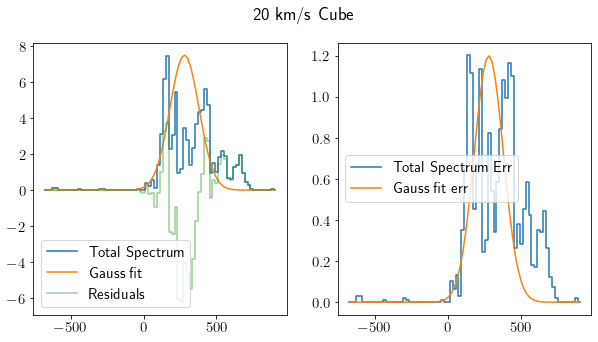

In [29]:
# Total Spectrum: Single Gaussian Fit

mu, sigma, amp = 280, 100, 7.5
err_amp = 1.2


flux, flux_err, spectral_axis = af.extract_cube_spectrum(total_region_cube, sigma_clip=3)

#plot single gaussian fit and error
fig, axes = plt.subplots(1,2, figsize=(10,5))
axs = axes.ravel()

ax = axs[0]
ax.step(spectral_axis, flux, where='mid', label='Total Spectrum')
ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
        label='Gauss fit')
ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                where='mid', alpha=0.5, label = 'Residuals')
ax.legend()

ax = axs[1]
ax.step(spectral_axis, flux_err, where='mid', label='Total Spectrum Err')
ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, err_amp), 
        label='Gauss fit err')
ax.legend()

fig.suptitle('20 km/s Cube')

#estimate gaussian integral
tot_single_gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
tot_single_gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=err_amp)

#estimate direct integral
tot_single_direct_integral = np.trapz(flux, spectral_axis)
tot_single_direct_integral_err = np.trapz(flux_err, spectral_axis)



In [38]:
print(f"Gaussian integral: {tot_single_gauss_integral[0]}")

integral_units = ((u.mJy * u.km)/u.s)
tot_mass = af.mass_time(tot_single_gauss_integral[0] * integral_units, 
                        tot_single_gauss_integral_err[0] * integral_units)

print(f"Direct integral: {tot_single_direct_integral}")
tot_mass_direct = af.mass_time(tot_single_direct_integral * integral_units, 
                        tot_single_direct_integral_err * integral_units)



Gaussian integral: 1879.9712055501075
H2 mass: 4.17E+10 solMass +/- 6.68E+09 solMass
Direct integral: 1652.2122014290662
H2 mass: 3.67E+10 solMass +/- 8.21E+09 solMass


The residuals are very large wih a single gaussian fit, as expected. We can reduce them using a multi-gaussian fit, but it won't be perfect since the shape of the spectrum is clearly not perfectly gaussian

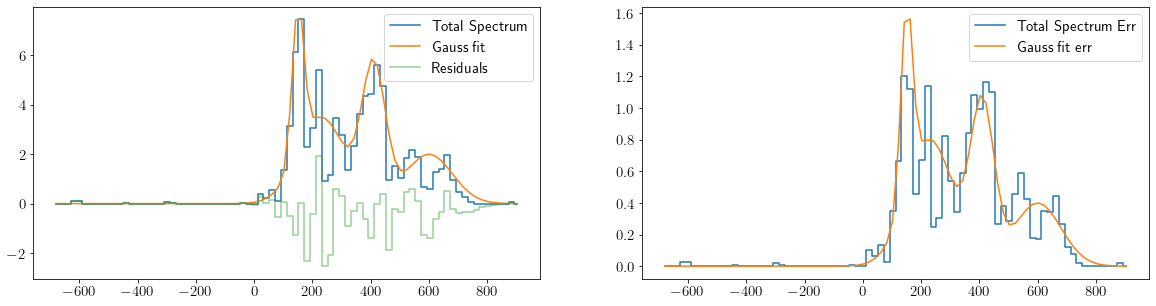

In [49]:
# Total Spectrum: Multi-Gaussian Fit

mus = [150, 230, 410, 600]
sigmas = [20, 80, 40, 80]
amps = [6, 3.5, 5.5, 2.]
err_amps = [1.2, 0.8, 1., 0.4]

flux, flux_err, spectral_axis = af.extract_cube_spectrum(total_region_cube, sigma_clip=3)

fig, axes = plt.subplots(1,2, figsize=(20,5))
axs = axes.ravel()

#flux
ax = axs[0]
ax.step(spectral_axis, flux, where='mid', label='Total Spectrum')

mg_fit = af.multi_gaussian_fit(spectral_axis, mus, sigmas, amps)
ax.plot(spectral_axis, mg_fit, label='Gauss fit')

ax.step(spectral_axis, af.residuals(mg_fit, flux), where='mid', alpha=0.5, label = 'Residuals')
ax.legend()

#flux err
ax = axs[1]
ax.step(spectral_axis, flux_err, where='mid', label='Total Spectrum Err')

mg_fit_err = af.multi_gaussian_fit(spectral_axis, mus, sigmas, err_amps)
ax.plot(spectral_axis, mg_fit_err, label='Gauss fit err')
ax.legend()


#estimate gaussian integral
tot_multi_gauss_integral = af.multi_gauss_integral(spectral_axis, mus, sigmas, amps)
tot_multi_gauss_integral_err = af.multi_gauss_integral(spectral_axis, mus, sigmas, err_amps)

#estimate direct integral
tot_direct_integral = np.trapz(flux, spectral_axis)
tot_direct_integral_err = np.trapz(flux_err, spectral_axis)


In [46]:
print("Total Gaussian integral: {} +/- {}".format(tot_multi_gauss_integral, tot_multi_gauss_integral_err))

integral_units = ((u.mJy * u.km)/u.s)
tot_mass = af.mass_time(tot_multi_gauss_integral * integral_units, 
                        tot_multi_gauss_integral_err * integral_units)

print("Total Direct integral: {}".format(tot_direct_integral))
tot_mass_tot_direct = af.mass_time(tot_direct_integral * integral_units, 
                        tot_direct_integral_err * integral_units)



Gaussian integral: 1955.140381826903 +/- 401.0545894639047
H2 mass: 4.34E+10 solMass +/- 8.90E+09 solMass
Direct integral: 1652.2122014290662
H2 mass: 3.67E+10 solMass +/- 8.21E+09 solMass


## 2. Mass Distribution of Gas Through North, Center and South Regions

North Gaussian integral: 757.0017389385623 +/- 135.35792683007406
H2 mass: 1.68E+10 solMass +/- 3.00E+09 solMass
North Direct integral: 772.0797804825927
H2 mass: 1.71E+10 solMass +/- 3.53E+09 solMass


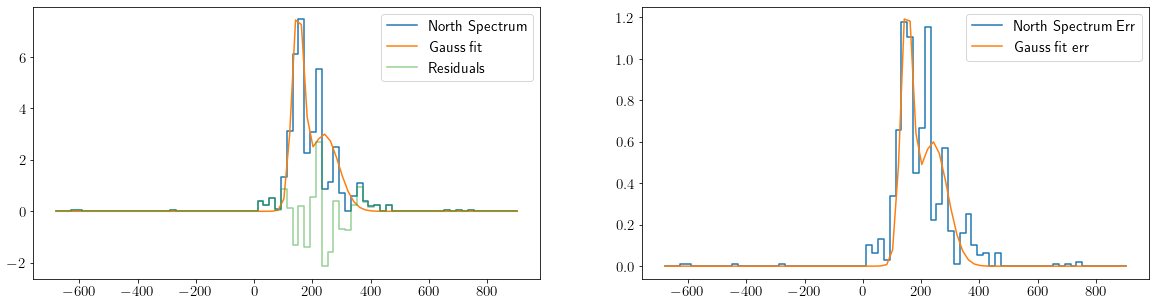

In [51]:
# North Spectrum: Multi-Gaussian Fit

mus = [150, 240]
sigmas = [20, 50]
amps = [7.6, 3]
err_amps = [1.2, 0.6]

flux, flux_err, spectral_axis = af.extract_cube_spectrum(north_region_cube, sigma_clip=3)

fig, axes = plt.subplots(1,2, figsize=(20,5))
axs = axes.ravel()

#flux
ax = axs[0]
ax.step(spectral_axis, flux, where='mid', label='North Spectrum')

mg_fit = af.multi_gaussian_fit(spectral_axis, mus, sigmas, amps)
ax.plot(spectral_axis, mg_fit, label='Gauss fit')

ax.step(spectral_axis, af.residuals(mg_fit, flux), where='mid', alpha=0.5, label = 'Residuals')
ax.legend()

#flux err
ax = axs[1]
ax.step(spectral_axis, flux_err, where='mid', label='North Spectrum Err')

mg_fit_err = af.multi_gaussian_fit(spectral_axis, mus, sigmas, err_amps)
ax.plot(spectral_axis, mg_fit_err, label='Gauss fit err')
ax.legend()


#estimate gaussian integral
north_multi_gauss_integral = af.multi_gauss_integral(spectral_axis, mus, sigmas, amps)
north_multi_gauss_integral_err = af.multi_gauss_integral(spectral_axis, mus, sigmas, err_amps)

#estimate direct integral
north_direct_integral = np.trapz(flux, spectral_axis)
north_direct_integral_err = np.trapz(flux_err, spectral_axis)

print("North Gaussian integral: {} +/- {}".format(north_multi_gauss_integral, north_multi_gauss_integral_err))

integral_units = ((u.mJy * u.km)/u.s)
north_mass = af.mass_time(north_multi_gauss_integral * integral_units, 
                        north_multi_gauss_integral_err * integral_units)

print("North Direct integral: {}".format(north_direct_integral))
north_mass_north_direct = af.mass_time(north_direct_integral * integral_units, 
                        north_direct_integral_err * integral_units)

Gaussian integral: 551.4582204188201
H2 mass: 1.22E+10 solMass +/- 2.56E+09 solMass
Direct integral: 633.8058110326513
H2 mass: 1.41E+10 solMass +/- 3.38E+09 solMass


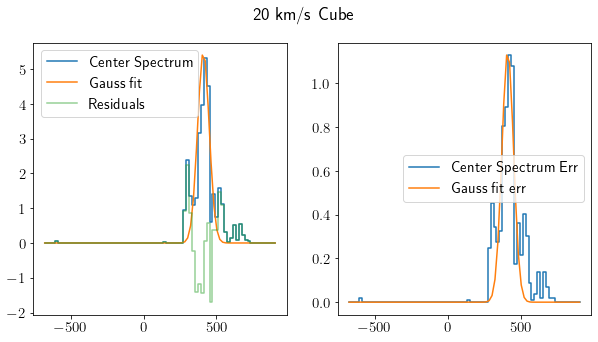

In [54]:
# Center Spectrum: Single Gaussian Fit

mu, sigma, amp = 410, 40, 5.5
err_amp = 1.15

flux, flux_err, spectral_axis = af.extract_cube_spectrum(center_region_cube, sigma_clip=3)

#plot single gaussian fit and error
fig, axes = plt.subplots(1,2, figsize=(10,5))
axs = axes.ravel()

ax = axs[0]
ax.step(spectral_axis, flux, where='mid', label='Center Spectrum')
ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
        label='Gauss fit')
ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                where='mid', alpha=0.5, label = 'Residuals')
ax.legend()

ax = axs[1]
ax.step(spectral_axis, flux_err, where='mid', label='Center Spectrum Err')
ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, err_amp), 
        label='Gauss fit err')
ax.legend()

fig.suptitle('20 km/s Cube')

#estimate gaussian integral
center_single_gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
center_single_gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=err_amp)

#estimate direct integral
center_single_direct_integral = np.trapz(flux, spectral_axis)
center_single_direct_integral_err = np.trapz(flux_err, spectral_axis)

print(f"Gaussian integral: {center_single_gauss_integral[0]}")

integral_units = ((u.mJy * u.km)/u.s)
center_mass = af.mass_time(center_single_gauss_integral[0] * integral_units, 
                        center_single_gauss_integral_err[0] * integral_units)

print(f"Direct integral: {center_single_direct_integral}")
center_mass_direct = af.mass_time(center_single_direct_integral * integral_units, 
                        center_single_direct_integral_err * integral_units)

Gaussian integral: 551.4484572091192
H2 mass: 1.22E+10 solMass +/- 2.78E+09 solMass
Direct integral: 560.7856462659839
H2 mass: 1.24E+10 solMass +/- 3.17E+09 solMass


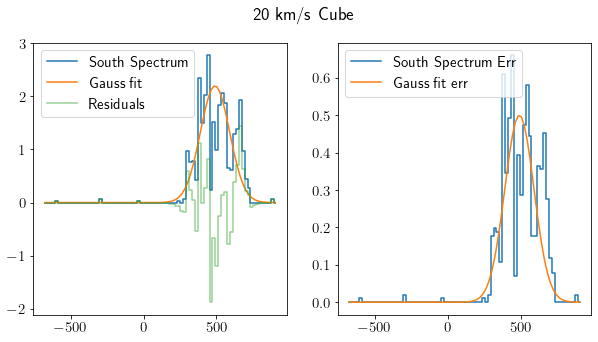

In [60]:

# South Spectrum: Single Gaussian Fit

mu, sigma, amp = 490, 100, 2.2
err_amp = 0.5

flux, flux_err, spectral_axis = af.extract_cube_spectrum(south_region_cube, sigma_clip=3)

#plot single gaussian fit and error
fig, axes = plt.subplots(1,2, figsize=(10,5))
axs = axes.ravel()

ax = axs[0]
ax.step(spectral_axis, flux, where='mid', label='South Spectrum')
ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
        label='Gauss fit')
ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                where='mid', alpha=0.5, label = 'Residuals')
ax.legend()

ax = axs[1]
ax.step(spectral_axis, flux_err, where='mid', label='South Spectrum Err')
ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, err_amp), 
        label='Gauss fit err')
ax.legend()

fig.suptitle('20 km/s Cube')

#estimate gaussian integral
south_single_gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
south_single_gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=err_amp)

#estimate direct integral
south_single_direct_integral = np.trapz(flux, spectral_axis)
south_single_direct_integral_err = np.trapz(flux_err, spectral_axis)

print(f"Gaussian integral: {south_single_gauss_integral[0]}")

integral_units = ((u.mJy * u.km)/u.s)
south_mass = af.mass_time(south_single_gauss_integral[0] * integral_units, 
                        south_single_gauss_integral_err[0] * integral_units)

print(f"Direct integral: {south_single_direct_integral}")
south_mass_direct = af.mass_time(south_single_direct_integral * integral_units, 
                        south_single_direct_integral_err * integral_units)

In [61]:
north_mass

(<Quantity 1.67991279e+10 solMass>, <Quantity 3.00381757e+09 solMass>, None)

In [63]:
print("\n for a velocity resolution of 20 km/s, {:.1f}% of the gas is concentrated in the north, \n" \
                " {:.1f}% of the gas is concentrated in the center, and {:.1f}% of the gas is concentrated \n "\
                        "in the south".format(north_mass[0]*100/tot_mass[0], center_mass[0]*100/tot_mass[0],
                                                                south_mass[0]*100/tot_mass[0]))


 for a velocity resolution of 20 km/s, 38.7% of the gas is concentrated in the north, 
 28.2% of the gas is concentrated in the center, and 28.2% of the gas is concentrated 
 in the south


## 3. Do Velocity Resolution and Weighting Impact the Total Gas Mass?


In [65]:
#list of cubes
vwcube_files = []
weights = ['briggs', 'natural']
velocity_resolutions = [10, 20, 40, 80]

#list of cubes
for idw, weight in enumerate(weights):
    for idv, vel in enumerate(velocity_resolutions):
        vwcube_files.append(''.join((my_path, 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_{}kms_{}_notaper'
                        '.image.pbcor.fits'.format(vel, weight))))


In [67]:
#moment files for each cube
m0_files = [vwfile[:-5]+ '_M0.fits' for vwfile in vwcube_files]
m1_files = [vwfile[:-5]+ '_M1.fits' for vwfile in vwcube_files]
m2_files = [vwfile[:-5]+ '_M2.fits' for vwfile in vwcube_files]

In [68]:
m0cmap, m1cmap, m2cmap =sns.light_palette("seagreen", as_cmap=True), cm.Blues,  sns.color_palette("mako_r", as_cmap=True)

In [71]:
m0_files[-4:]

['/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_10kms_natural_notaper.image.pbcor_M0.fits',
 '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M0.fits',
 '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_40kms_natural_notaper.image.pbcor_M0.fits',
 '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_80kms_natural_notaper.image.pbcor_M0.fits']

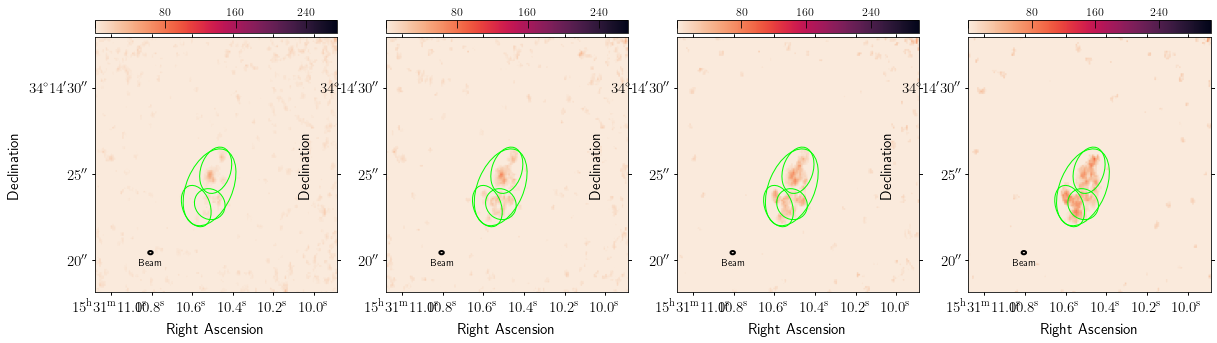

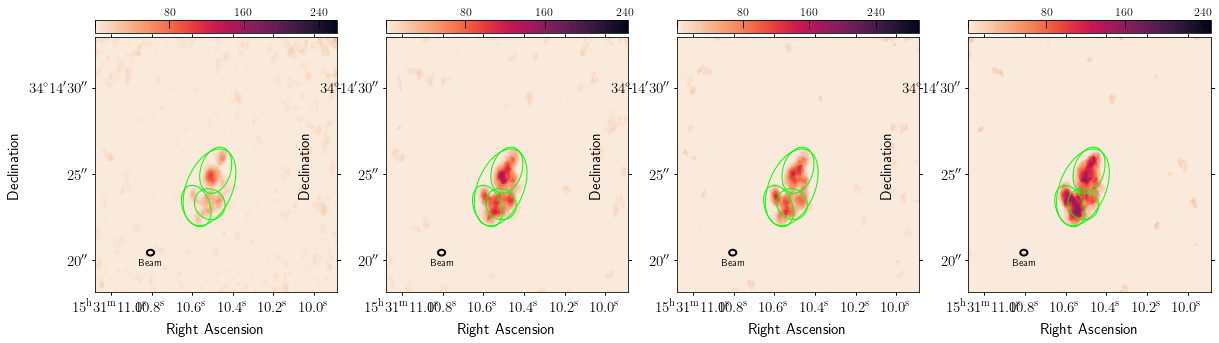

In [72]:
hdu, header, wcs = pf.open_fits(m0_files[0], naxis=2)

#briggs
fig = pf.plot_all_moments(m0_files[:-4], header, region_string=region_string, ncols=4)

#natural
fig = pf.plot_all_moments(m0_files[-4:], header, region_string=region_string, ncols=4)

In [73]:
vwregion_cubes = []

for idr, region_type in enumerate(regions):

    vwap_cubes = []
    print('region: {}'.format(idr))

    for idw, vwile in enumerate(vwcube_files):
        if idw <4:
            print('briggs weight: {}'.format(idw))

        else:
            print('natural weight: {}'.format(idw))

        cube = SpectralCube.read(vwile)

        ap_cube = cube.subcube_from_regions(region_type) 

        vwap_cubes.append(ap_cube)

    vwregion_cubes.append(vwap_cubes)
    print('region: {}'.format(idr))

region: 0
briggs weight: 0
briggs weight: 1
briggs weight: 2
briggs weight: 3
natural weight: 4
natural weight: 5
natural weight: 6
natural weight: 7
region: 0
region: 1
briggs weight: 0
briggs weight: 1
briggs weight: 2
briggs weight: 3
natural weight: 4
natural weight: 5
natural weight: 6
natural weight: 7
region: 1
region: 2
briggs weight: 0
briggs weight: 1
briggs weight: 2
briggs weight: 3
natural weight: 4
natural weight: 5
natural weight: 6
natural weight: 7
region: 2
region: 3
briggs weight: 0
briggs weight: 1
briggs weight: 2
briggs weight: 3
natural weight: 4
natural weight: 5
natural weight: 6
natural weight: 7
region: 3


In [75]:
north_region_cubes = vwregion_cubes[0]
center_region_cubes = vwregion_cubes[1]
south_region_cubes = vwregion_cubes[2]
total_region_cubes = vwregion_cubes[3]


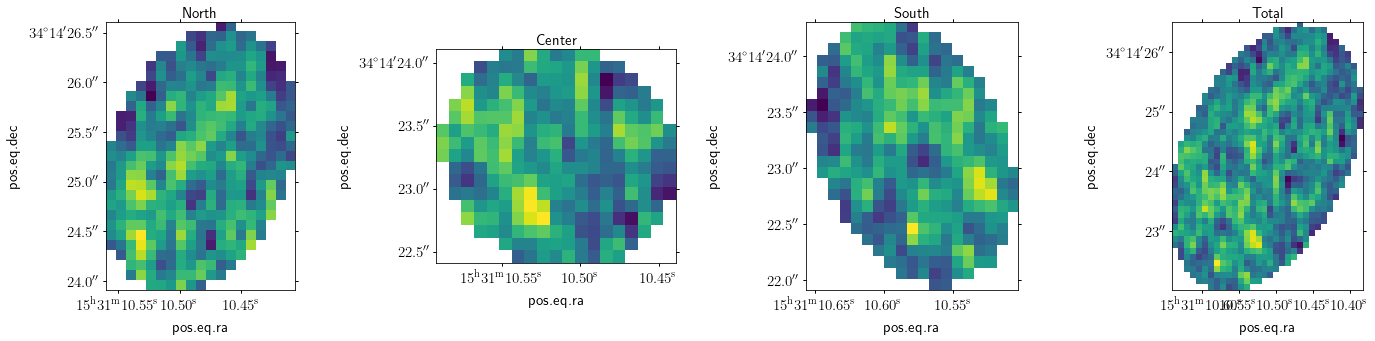

In [77]:
#check that the areas selected are correct
pf.styleplots()

fig = plt.figure(figsize=(20, 5))
gs1 = GridSpec(1,4)

plot_cubes = [north_region_cubes, center_region_cubes, south_region_cubes, total_region_cubes]

for idx in range(4):
    plot_cube = plot_cubes[idx][1]

    ax = fig.add_subplot(gs1[idx], projection=WCS(plot_cube.header), slices=('x', 'y', 0))
    ax.imshow(plot_cube.moment(order=0).data)
    ax.set_title(region_names[idx])

fig.tight_layout()



#### Single Gaussian Fits to the Total Region in each velcoity/resolution/weighting scheme

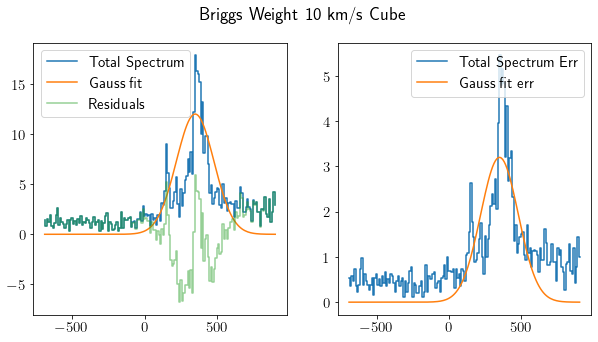

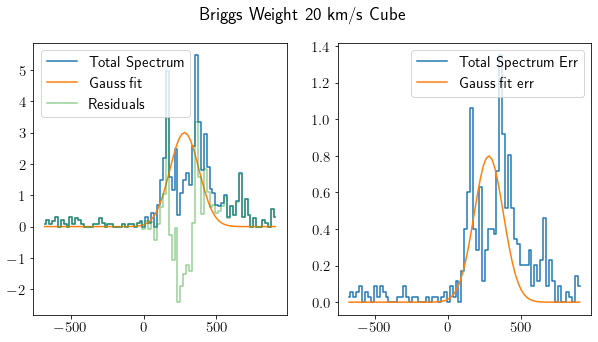

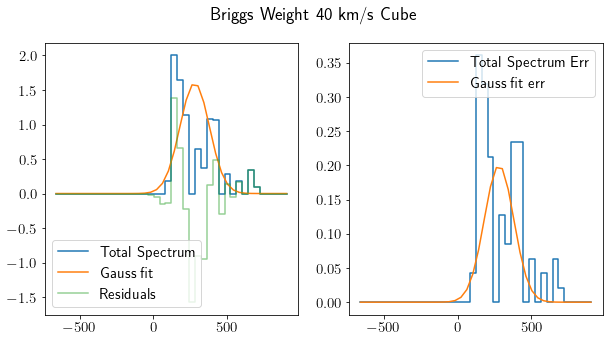

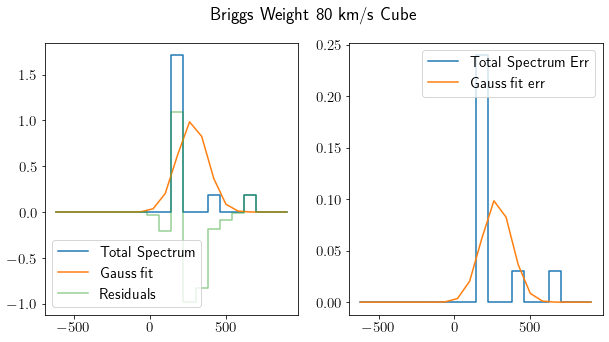

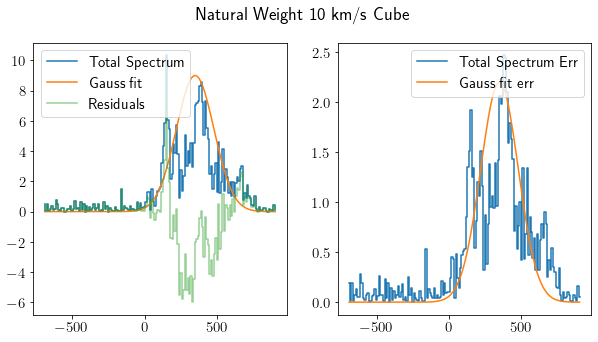

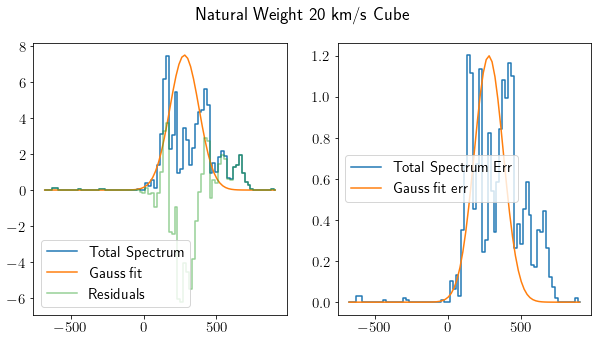

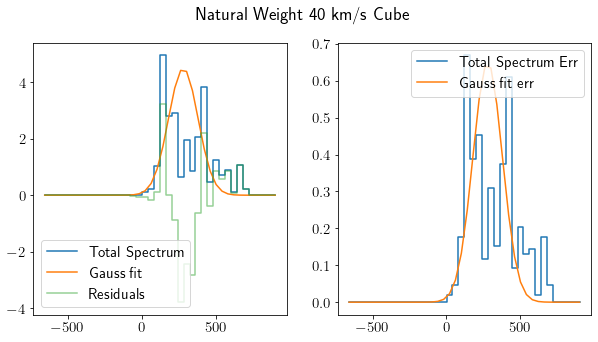

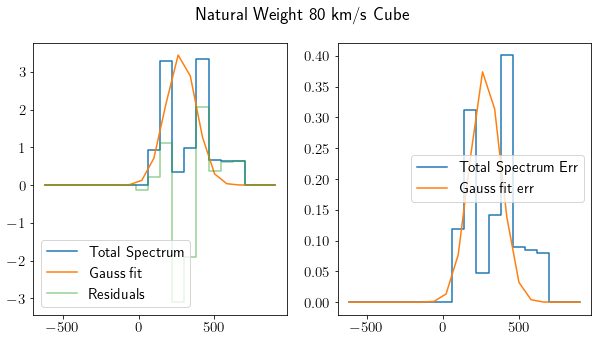

In [83]:
# Total Spectrum: Single Gaussian Fit

mus = [350, 280, 280, 280, 350, 280, 280, 280]
sigmas = [130, 100, 100, 100, 130, 100, 100, 100]
amps = [12, 3, 1.6, 1, 9, 7.5, 4.5, 3.5]
err_amps = [3.2, 0.8, 0.2, 0.1, 2.2, 1.2, 0.65, 0.38]

tot_gintegrals = []
tot_gintegral_errs = []

tot_dintegrals = []
tot_dintegral_errs = []

for idt, tcube in enumerate(total_region_cubes):

    flux, flux_err, spectral_axis = af.extract_cube_spectrum(tcube, sigma_clip=3)

    #plot single gaussian fit and error
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axs = axes.ravel()

    ax = axs[0]
    ax.step(spectral_axis, flux, where='mid', label='Total Spectrum')

    mu, sigma, amp = mus[idt], sigmas[idt], amps[idt]
    ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
            label='Gauss fit')
    ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                    where='mid', alpha=0.5, label = 'Residuals')
    ax.legend()

    ax = axs[1]
    ax.step(spectral_axis, flux_err, where='mid', label='Total Spectrum Err')

    mu, sigma, err_amp = mus[idt], sigmas[idt], err_amps[idt]
    ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, err_amp), 
            label='Gauss fit err')
    ax.legend()

    if idt < 4:
        fig.suptitle(f'Briggs Weight {velocity_resolutions[idt]} km/s Cube')
    else:
        fig.suptitle(f'Natural Weight {velocity_resolutions[idt - 4]} km/s Cube')
 

    #estimate gaussian integral
    tot_single_gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
    tot_single_gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=err_amp)

    #estimate direct integral
    tot_single_direct_integral = np.trapz(flux, spectral_axis)
    tot_single_direct_integral_err = np.trapz(flux_err, spectral_axis)

    tot_gintegrals.append(tot_single_gauss_integral[0])
    tot_gintegral_errs.append(tot_single_gauss_integral_err[0])
    tot_dintegrals.append(tot_single_direct_integral)
    tot_dintegral_errs.append(tot_single_direct_integral_err)


In [85]:
total_masses = []
for idw, weight in enumerate(weights):
    print("\n Weighting: {}".format(weight))

    if idw == 0:
        for idv, vres in enumerate(velocity_resolutions):
            print("\n Velocity resolution: {} km/s".format(vres))

            print("Gaussian integral: {}".format(tot_gintegrals[idv]))
            integral_units = ((u.mJy * u.km)/u.s)
            tot_mass = af.mass_time(tot_gintegrals[idv] * integral_units, 
                                    tot_gintegral_errs[idv] * integral_units)

            print("Direct integral: {}".format(tot_dintegrals[idv]))
            tot_mass_direct = af.mass_time(tot_dintegrals[idv] * integral_units, 
                                    tot_dintegral_errs[idv] * integral_units)
            
    if idw == 1:
        for idv_i, vres in enumerate(velocity_resolutions):
            print("\n Velocity resolution: {} km/s".format(vres))
            idv = idv_i + 4

            print("Gaussian integral: {}".format(tot_gintegrals[idv]))
            integral_units = ((u.mJy * u.km)/u.s)
            tot_mass = af.mass_time(tot_gintegrals[idv] * integral_units, 
                                    tot_gintegral_errs[idv] * integral_units)

            print("Direct integral: {}".format(tot_dintegrals[idv]))
            tot_mass_direct = af.mass_time(tot_dintegrals[idv] * integral_units, 
                                    tot_dintegral_errs[idv] * integral_units)

        total_masses.append(tot_mass)



 Weighting: briggs

 Velocity resolution: 10 km/s
Gaussian integral: 3910.2999269473557
H2 mass: 8.68E+10 solMass +/- 2.31E+10 solMass
Direct integral: 4829.71411759716
H2 mass: 1.07E+11 solMass +/- 3.65E+10 solMass

 Velocity resolution: 20 km/s
Gaussian integral: 751.9884822200431
H2 mass: 1.67E+10 solMass +/- 4.45E+09 solMass
Direct integral: 1099.616213003611
H2 mass: 2.44E+10 solMass +/- 6.53E+09 solMass

 Velocity resolution: 40 km/s
Gaussian integral: 401.0605238496554
H2 mass: 8.90E+09 solMass +/- 1.11E+09 solMass
Direct integral: 361.7829374201064
H2 mass: 8.03E+09 solMass +/- 1.61E+09 solMass

 Velocity resolution: 80 km/s
Gaussian integral: 250.66282740473537
H2 mass: 5.56E+09 solMass +/- 5.56E+08 solMass
Direct integral: 167.0562992409425
H2 mass: 3.71E+09 solMass +/- 5.36E+08 solMass

 Weighting: natural

 Velocity resolution: 10 km/s
Gaussian integral: 2932.724945210516
H2 mass: 6.51E+10 solMass +/- 1.59E+10 solMass
Direct integral: 2522.3272624484343
H2 mass: 5.60E+10 s

### There is variation within a factor of 4 for the integrals across velocity resolution and within a factor of 2 for weighting scheme